# RiceHacks - PoseLively.AI

Import all required libraries

In [25]:
import cv2
import math
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score # Accuracy metrics 
import pickle


from time import time
from mpl_toolkits.mplot3d import Axes3D

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping


### Initiate mediapipe

In [26]:
mp_drawing = mp.solutions.drawing_utils # mediapipe drawing :D
mp_pose = mp.solutions.pose # mediapipe pose class.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2) # Setting up the Pose function.

---

# Test out video

Hit 'Q' Key on the keyboard to stop camera

In [59]:
cap = cv2.VideoCapture(1)  #Might need to change from 1 to a different number... default system camera is usually 0.
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark

        except:
            pass
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

---

## Production

In [27]:
len(landmarks) #get total number of landmarks/points

33

Printing the names of each point

In [28]:
for landmark in mp_pose.PoseLandmark:
    print(landmark)

PoseLandmark.NOSE
PoseLandmark.LEFT_EYE_INNER
PoseLandmark.LEFT_EYE
PoseLandmark.LEFT_EYE_OUTER
PoseLandmark.RIGHT_EYE_INNER
PoseLandmark.RIGHT_EYE
PoseLandmark.RIGHT_EYE_OUTER
PoseLandmark.LEFT_EAR
PoseLandmark.RIGHT_EAR
PoseLandmark.MOUTH_LEFT
PoseLandmark.MOUTH_RIGHT
PoseLandmark.LEFT_SHOULDER
PoseLandmark.RIGHT_SHOULDER
PoseLandmark.LEFT_ELBOW
PoseLandmark.RIGHT_ELBOW
PoseLandmark.LEFT_WRIST
PoseLandmark.RIGHT_WRIST
PoseLandmark.LEFT_PINKY
PoseLandmark.RIGHT_PINKY
PoseLandmark.LEFT_INDEX
PoseLandmark.RIGHT_INDEX
PoseLandmark.LEFT_THUMB
PoseLandmark.RIGHT_THUMB
PoseLandmark.LEFT_HIP
PoseLandmark.RIGHT_HIP
PoseLandmark.LEFT_KNEE
PoseLandmark.RIGHT_KNEE
PoseLandmark.LEFT_ANKLE
PoseLandmark.RIGHT_ANKLE
PoseLandmark.LEFT_HEEL
PoseLandmark.RIGHT_HEEL
PoseLandmark.LEFT_FOOT_INDEX
PoseLandmark.RIGHT_FOOT_INDEX


Looking at the output of a point:

In [29]:
landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value]

x: 0.47461537
y: -0.028051008
z: -0.081814535
visibility: 0.99918747

We see that we get X,Y,Z coords and visibility

Time to name these points so we can store it on a csv later

In [30]:
classes = ['class']
for val in range(1, 33+1):
    classes += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'visibility{}'.format(val)]

In [67]:
classes

['class',
 'x1',
 'y1',
 'z1',
 'visibility1',
 'x2',
 'y2',
 'z2',
 'visibility2',
 'x3',
 'y3',
 'z3',
 'visibility3',
 'x4',
 'y4',
 'z4',
 'visibility4',
 'x5',
 'y5',
 'z5',
 'visibility5',
 'x6',
 'y6',
 'z6',
 'visibility6',
 'x7',
 'y7',
 'z7',
 'visibility7',
 'x8',
 'y8',
 'z8',
 'visibility8',
 'x9',
 'y9',
 'z9',
 'visibility9',
 'x10',
 'y10',
 'z10',
 'visibility10',
 'x11',
 'y11',
 'z11',
 'visibility11',
 'x12',
 'y12',
 'z12',
 'visibility12',
 'x13',
 'y13',
 'z13',
 'visibility13',
 'x14',
 'y14',
 'z14',
 'visibility14',
 'x15',
 'y15',
 'z15',
 'visibility15',
 'x16',
 'y16',
 'z16',
 'visibility16',
 'x17',
 'y17',
 'z17',
 'visibility17',
 'x18',
 'y18',
 'z18',
 'visibility18',
 'x19',
 'y19',
 'z19',
 'visibility19',
 'x20',
 'y20',
 'z20',
 'visibility20',
 'x21',
 'y21',
 'z21',
 'visibility21',
 'x22',
 'y22',
 'z22',
 'visibility22',
 'x23',
 'y23',
 'z23',
 'visibility23',
 'x24',
 'y24',
 'z24',
 'visibility24',
 'x25',
 'y25',
 'z25',
 'visibility25',
 

Now, we take 'Classes' from before make a CSV file in the directory

In [71]:
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(classes)

Now we take a custom class_name, which can be a classifer in our future model

## Creating custom model based on camera input

In [76]:
class_name = "Bicep curl"
CSV_FILE = 'coords.csv'

Hit 'Q' key on the keyboard to stop camera

In [53]:
cap = cv2.VideoCapture(1) #Might need to change from 1 to a different number... default system camera is usually 0.
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            landmarks_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks]).flatten())
                        
            landmarks_row.insert(0, class_name)
            
            #Export to CSV
            with open(CSV_FILE, mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(landmarks_row)
                       
        except:
            pass
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

We will use the CSV file to train models later in this notebook

---

### Testing on images

Read an image, get posture mapped out, and display it

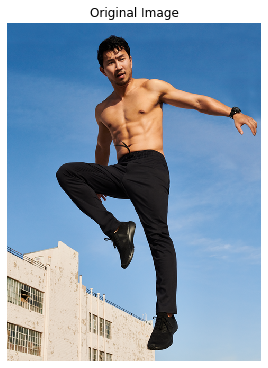

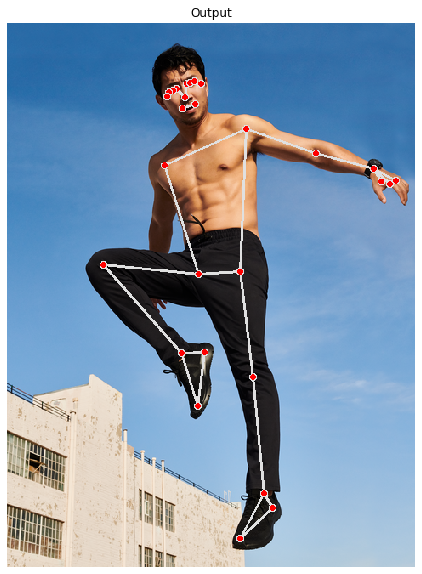

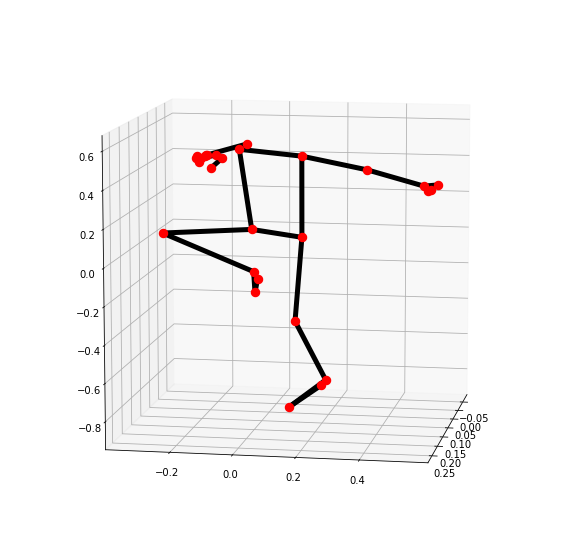

In [51]:
# Read an image from the specified path.
sample_img = cv2.imread('media/simu.png')
# Make a copy of the image
output_image = sample_img.copy()

# CONVERT IMAGE and do pose detection
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))


# Display the original input image and the resultant image.
plt.figure(figsize=[10,10])
plt.subplot(121)  
plt.imshow(sample_img[:,:,::-1])
plt.title("Original Image")
plt.axis('off')
# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(output_image[:,:,::-1]);plt.show()
    
    
# Ploting the Pose landmarks in 3D.
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

plt.show()


Super cool!!
Now, we lets look at results

In [262]:
results.pose_landmarks

landmark {
  x: 0.43632957
  y: 0.13630107
  z: -0.2965941
  visibility: 0.9999943
}
landmark {
  x: 0.44020507
  y: 0.11223576
  z: -0.27106273
  visibility: 0.99999106
}
landmark {
  x: 0.44996646
  y: 0.10946894
  z: -0.27152404
  visibility: 0.9999901
}
landmark {
  x: 0.4588796
  y: 0.10751381
  z: -0.2713683
  visibility: 0.9999931
}
landmark {
  x: 0.41575086
  y: 0.121736504
  z: -0.25891992
  visibility: 0.9999931
}
landmark {
  x: 0.40685666
  y: 0.12469187
  z: -0.25965083
  visibility: 0.9999919
}
landmark {
  x: 0.397426
  y: 0.12741187
  z: -0.25995165
  visibility: 0.99999094
}
landmark {
  x: 0.47621292
  y: 0.1116966
  z: -0.11069659
  visibility: 0.9999945
}
landmark {
  x: 0.39334792
  y: 0.1354715
  z: -0.052176822
  visibility: 0.9999802
}
landmark {
  x: 0.46215498
  y: 0.1484673
  z: -0.23220143
  visibility: 0.9999863
}
landmark {
  x: 0.42940417
  y: 0.15726325
  z: -0.21929167
  visibility: 0.99996936
}
landmark {
  x: 0.58670175
  y: 0.19508809
  z: -0.062612

We can see now that we can input an image and get 3d coordinates of it

In [264]:
landmark_results = results.pose_landmarks.landmark

In [245]:
landmark_results[32]

x: 0.75734854
y: 0.72828174
z: 0.27926442
visibility: 0.020035772

In [66]:
landmarks_results_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmark_results]).flatten())

---

## Training ML model on yoga datsets

In [62]:
dir = 'yoga_dataset/DATASET'        #Directory of our data

__Printing random pics from each classification folder in training data__

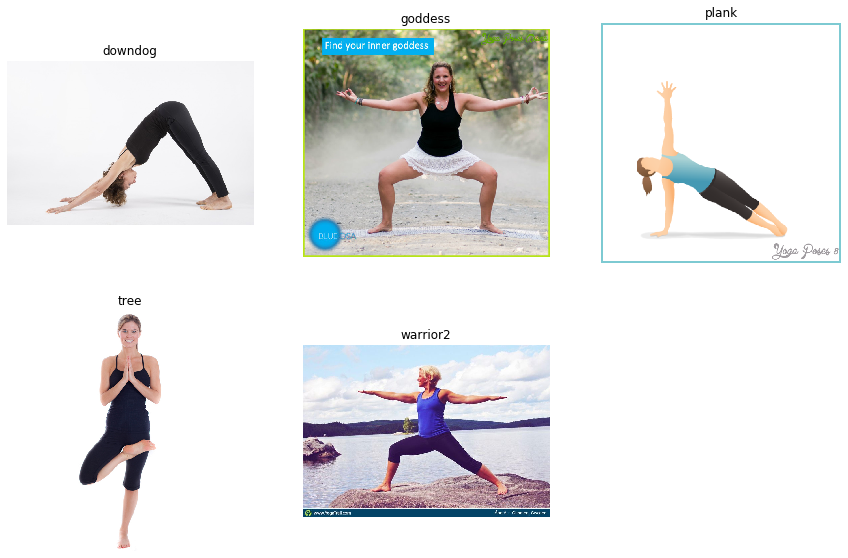

In [70]:
plt.figure(figsize = (15,15))
for i, col in enumerate(os.listdir(dir)):
        image = random.choice(os.listdir(dir + '/' + col))
        image_path = dir + '/' + col + '/' + image
        img = cv2.imread(image_path)
        plt.subplot(3,3,i+1)
        plt.title(col)
        plt.imshow(img[:,:,::-1])
        plt.axis(False)
        i = i + 1
        

## Preprocessing data

Defining the column names for dataset

In [36]:
classes = ['class']
for val in range(1, 33+1):
    classes += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'visibility{}'.format(val)]

Initiating empty CSV file

In [37]:
with open('coords_2.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(classes)

Going to the data directory, and converting all images into datapoints from mediapipe

Warning: this will take a while, go grab a cup of water...

In [38]:
for col in enumerate(os.listdir(dir)):
    for file in range(len([f for f in os.listdir(dir + '/' + col[1])if os.path.isfile(os.path.join(dir + '/' + col[1], f))])):
        img_path = dir + '/' + col[1] + '/' + os.listdir(dir + '/' + col[1])[file]
        sample_img = cv2.imread(img_path)
        print(img_path)
        class_name = col[1]
        results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
        if results.pose_landmarks: #To make sure if results exists! very important, else will get NoneType error if image cant be recognized
            landmarks = results.pose_landmarks.landmark
            landmarks_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks]).flatten())
                        
            landmarks_row.insert(0, class_name)
        
        #Export to CSV
            with open('coords_2.csv', mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(landmarks_row)
        

yoga_dataset/DATASET/downdog/00000000.jpg
yoga_dataset/DATASET/downdog/00000001.JPG
yoga_dataset/DATASET/downdog/00000002.jpg
yoga_dataset/DATASET/downdog/00000003.jpg
yoga_dataset/DATASET/downdog/00000004.jpg
yoga_dataset/DATASET/downdog/00000005.jpg
yoga_dataset/DATASET/downdog/00000006.jpg
yoga_dataset/DATASET/downdog/00000007.jpg
yoga_dataset/DATASET/downdog/00000008.jpg
yoga_dataset/DATASET/downdog/00000009.jpg
yoga_dataset/DATASET/downdog/00000010.png
yoga_dataset/DATASET/downdog/00000011.jpg
yoga_dataset/DATASET/downdog/00000012.jpg
yoga_dataset/DATASET/downdog/00000013.jpg
yoga_dataset/DATASET/downdog/00000014.jpg
yoga_dataset/DATASET/downdog/00000016.jpg
yoga_dataset/DATASET/downdog/00000017.png
yoga_dataset/DATASET/downdog/00000018.jpg
yoga_dataset/DATASET/downdog/00000019.jpg
yoga_dataset/DATASET/downdog/00000020.jpg
yoga_dataset/DATASET/downdog/00000021.jpg
yoga_dataset/DATASET/downdog/00000022.jpg
yoga_dataset/DATASET/downdog/00000023.jpg
yoga_dataset/DATASET/downdog/00000

yoga_dataset/DATASET/downdog/00000251.jpg
yoga_dataset/DATASET/downdog/00000254.jpg
yoga_dataset/DATASET/downdog/00000255.jpg
yoga_dataset/DATASET/downdog/00000258.jpg
yoga_dataset/DATASET/downdog/00000263.jpg
yoga_dataset/DATASET/downdog/00000264.jpg
yoga_dataset/DATASET/downdog/00000266.jpg
yoga_dataset/DATASET/downdog/00000268.jpg
yoga_dataset/DATASET/downdog/00000270.jpg
yoga_dataset/DATASET/downdog/00000272.jpg
yoga_dataset/DATASET/downdog/00000274.jpg
yoga_dataset/DATASET/downdog/00000276.jpg
yoga_dataset/DATASET/downdog/00000277.jpg
yoga_dataset/DATASET/downdog/00000278.jpg
yoga_dataset/DATASET/downdog/00000279.jpg
yoga_dataset/DATASET/downdog/00000280.jpg
yoga_dataset/DATASET/downdog/00000281.jpg
yoga_dataset/DATASET/downdog/00000283.jpg
yoga_dataset/DATASET/downdog/00000284.jpg
yoga_dataset/DATASET/downdog/00000285.jpg
yoga_dataset/DATASET/downdog/00000286.jpg
yoga_dataset/DATASET/downdog/00000287.png
yoga_dataset/DATASET/downdog/00000288.jpg
yoga_dataset/DATASET/downdog/00000

yoga_dataset/DATASET/goddess/00000088.jpg
yoga_dataset/DATASET/goddess/00000089.jpg
yoga_dataset/DATASET/goddess/00000090.jpg
yoga_dataset/DATASET/goddess/00000091.jpg
yoga_dataset/DATASET/goddess/00000092.png
yoga_dataset/DATASET/goddess/00000093.jpg
yoga_dataset/DATASET/goddess/00000095.jpeg
yoga_dataset/DATASET/goddess/00000096.jpg
yoga_dataset/DATASET/goddess/00000097.jpg
yoga_dataset/DATASET/goddess/00000100.jpg
yoga_dataset/DATASET/goddess/00000101.jpg
yoga_dataset/DATASET/goddess/00000102.jpg
yoga_dataset/DATASET/goddess/00000103.png
yoga_dataset/DATASET/goddess/00000104.jpeg
yoga_dataset/DATASET/goddess/00000105.jpg
yoga_dataset/DATASET/goddess/00000106.jpg
yoga_dataset/DATASET/goddess/00000107.jpg
yoga_dataset/DATASET/goddess/00000108.jpg
yoga_dataset/DATASET/goddess/00000110.jpg
yoga_dataset/DATASET/goddess/00000111.jpg
yoga_dataset/DATASET/goddess/00000112.jpg
yoga_dataset/DATASET/goddess/00000113.jpg
yoga_dataset/DATASET/goddess/00000114.jpg
yoga_dataset/DATASET/goddess/000

yoga_dataset/DATASET/plank/00000011.jpg
yoga_dataset/DATASET/plank/00000012.jpg
yoga_dataset/DATASET/plank/00000013.jpg
yoga_dataset/DATASET/plank/00000014.jpg
yoga_dataset/DATASET/plank/00000015.jpg
yoga_dataset/DATASET/plank/00000016.jpg
yoga_dataset/DATASET/plank/00000017.jpg
yoga_dataset/DATASET/plank/00000018.jpg
yoga_dataset/DATASET/plank/00000019.jpg
yoga_dataset/DATASET/plank/00000020.jpg
yoga_dataset/DATASET/plank/00000021.jpg
yoga_dataset/DATASET/plank/00000022.jpg
yoga_dataset/DATASET/plank/00000024.jpg
yoga_dataset/DATASET/plank/00000025.jpg
yoga_dataset/DATASET/plank/00000026.jpg
yoga_dataset/DATASET/plank/00000027.JPG
yoga_dataset/DATASET/plank/00000028.jpg
yoga_dataset/DATASET/plank/00000029.jpg
yoga_dataset/DATASET/plank/00000030.jpg
yoga_dataset/DATASET/plank/00000031.jpg
yoga_dataset/DATASET/plank/00000032.jpg
yoga_dataset/DATASET/plank/00000033.jpg
yoga_dataset/DATASET/plank/00000034.jpg
yoga_dataset/DATASET/plank/00000036.jpg
yoga_dataset/DATASET/plank/00000037.jpg


yoga_dataset/DATASET/plank/00000242.jpg
yoga_dataset/DATASET/plank/00000244.jpg
yoga_dataset/DATASET/plank/00000245.png
yoga_dataset/DATASET/plank/00000246.jpg
yoga_dataset/DATASET/plank/00000247.jpg
yoga_dataset/DATASET/plank/00000248.jpg
yoga_dataset/DATASET/plank/00000249.jpg
yoga_dataset/DATASET/plank/00000250.jpg
yoga_dataset/DATASET/plank/00000251.jpg
yoga_dataset/DATASET/plank/00000252.jpg
yoga_dataset/DATASET/plank/00000253.jpg
yoga_dataset/DATASET/plank/00000254.jpg
yoga_dataset/DATASET/plank/00000255.jpg
yoga_dataset/DATASET/plank/00000256.jpg
yoga_dataset/DATASET/plank/00000257.jpg
yoga_dataset/DATASET/plank/00000258.jpg
yoga_dataset/DATASET/plank/00000260.jpg
yoga_dataset/DATASET/plank/00000261.jpg
yoga_dataset/DATASET/plank/00000262.jpg
yoga_dataset/DATASET/plank/00000263.png
yoga_dataset/DATASET/plank/00000264.jpg
yoga_dataset/DATASET/plank/00000265.jpg
yoga_dataset/DATASET/plank/00000266.jpg
yoga_dataset/DATASET/plank/00000267.png
yoga_dataset/DATASET/plank/00000268.jpg


yoga_dataset/DATASET/tree/00000039.jpg
yoga_dataset/DATASET/tree/00000040.jpg
yoga_dataset/DATASET/tree/00000041.jpg
yoga_dataset/DATASET/tree/00000042.jpg
yoga_dataset/DATASET/tree/00000043.jpg
yoga_dataset/DATASET/tree/00000044.jpg
yoga_dataset/DATASET/tree/00000045.jpg
yoga_dataset/DATASET/tree/00000046.jpg
yoga_dataset/DATASET/tree/00000047.png
yoga_dataset/DATASET/tree/00000048.jpg
yoga_dataset/DATASET/tree/00000049.jpg
yoga_dataset/DATASET/tree/00000050.jpg
yoga_dataset/DATASET/tree/00000051.png
yoga_dataset/DATASET/tree/00000052.jpg
yoga_dataset/DATASET/tree/00000053.jpg
yoga_dataset/DATASET/tree/00000054.jpg
yoga_dataset/DATASET/tree/00000055.jpg
yoga_dataset/DATASET/tree/00000056.jpg
yoga_dataset/DATASET/tree/00000057.jpg
yoga_dataset/DATASET/tree/00000058.jpg
yoga_dataset/DATASET/tree/00000059.jpg
yoga_dataset/DATASET/tree/00000060.jpg
yoga_dataset/DATASET/tree/00000061.jpg
yoga_dataset/DATASET/tree/00000062.jpg
yoga_dataset/DATASET/tree/00000063.jpg
yoga_dataset/DATASET/tree

yoga_dataset/DATASET/warrior2/00000021.jpg
yoga_dataset/DATASET/warrior2/00000022.jpg
yoga_dataset/DATASET/warrior2/00000023.jpg
yoga_dataset/DATASET/warrior2/00000024.jpg
yoga_dataset/DATASET/warrior2/00000025.png
yoga_dataset/DATASET/warrior2/00000026.jpg
yoga_dataset/DATASET/warrior2/00000027.jpg
yoga_dataset/DATASET/warrior2/00000029.jpg
yoga_dataset/DATASET/warrior2/00000030.jpg
yoga_dataset/DATASET/warrior2/00000031.jpg
yoga_dataset/DATASET/warrior2/00000032.jpg
yoga_dataset/DATASET/warrior2/00000033.jpg
yoga_dataset/DATASET/warrior2/00000034.jpg
yoga_dataset/DATASET/warrior2/00000035.jpg
yoga_dataset/DATASET/warrior2/00000036.jpg
yoga_dataset/DATASET/warrior2/00000037.jpg
yoga_dataset/DATASET/warrior2/00000038.jpg
yoga_dataset/DATASET/warrior2/00000039.png
yoga_dataset/DATASET/warrior2/00000040.jpg
yoga_dataset/DATASET/warrior2/00000041.jpg
yoga_dataset/DATASET/warrior2/00000042.jpg
yoga_dataset/DATASET/warrior2/00000043.jpg
yoga_dataset/DATASET/warrior2/00000044.jpg
yoga_datase

yoga_dataset/DATASET/warrior2/00000247.jpg
yoga_dataset/DATASET/warrior2/00000248.jpg
yoga_dataset/DATASET/warrior2/00000249.jpg
yoga_dataset/DATASET/warrior2/00000250.png
yoga_dataset/DATASET/warrior2/00000251.jpg
yoga_dataset/DATASET/warrior2/00000253.jpg
yoga_dataset/DATASET/warrior2/00000254.jpg
yoga_dataset/DATASET/warrior2/00000255.jpg
yoga_dataset/DATASET/warrior2/00000256.jpg
yoga_dataset/DATASET/warrior2/00000257.jpg
yoga_dataset/DATASET/warrior2/00000258.jpg
yoga_dataset/DATASET/warrior2/00000259.jpg
yoga_dataset/DATASET/warrior2/00000260.jpg
yoga_dataset/DATASET/warrior2/00000264.jpg
yoga_dataset/DATASET/warrior2/00000265.jpg
yoga_dataset/DATASET/warrior2/00000266.jpg
yoga_dataset/DATASET/warrior2/00000267.jpg
yoga_dataset/DATASET/warrior2/00000268.jpg
yoga_dataset/DATASET/warrior2/00000269.jpg
yoga_dataset/DATASET/warrior2/00000270.jpg
yoga_dataset/DATASET/warrior2/00000271.jpg
yoga_dataset/DATASET/warrior2/00000272.jpg
yoga_dataset/DATASET/warrior2/00000273.jpg
yoga_datase

---

## Machine learning

### Spliting data into training and testing

Importing CSV file

In [82]:
#df = pd.read_csv('coords.csv') # self captured dataset

In [39]:
df = pd.read_csv('coords_2.csv') #yoga dataset

In [40]:
X = df.drop('class', axis=1) # features
y = df['class'] # target value

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69) #spliting data into training and testing

__Creating pipline for 6 models__

In [42]:
pipelines = {
    'lr':make_pipeline(RobustScaler(), LogisticRegression()),
    'rc':make_pipeline(RobustScaler(), RidgeClassifier()),
    'svc':make_pipeline(RobustScaler(), SVC()),
    'xgb':make_pipeline(RobustScaler(), XGBClassifier()),
    'rf':make_pipeline(RobustScaler(), RandomForestClassifier()),
    'gb':make_pipeline(RobustScaler(), GradientBoostingClassifier())
}

__Fitting models__

In [43]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

C:\Users\Isfan\anaconda3\envs\Capstone-NLP\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Isfan\anaconda3\envs\Capstone-NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecati

[01:40:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
fit_models

{'lr': Pipeline(memory=None,
          steps=[('robustscaler',
                  RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                               with_centering=True, with_scaling=True)),
                 ('logisticregression',
                  LogisticRegression(C=1.0, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False),
 'rc': Pipeline(memory=None,
          steps=[('robustscaler',
                  RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                               with_centering=True, with_scaling=True)),
                 ('ridgecla

__Checking for test accuracy__

In [46]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

lr 0.8911111111111111
rc 0.9155555555555556
svc 0.6755555555555556
xgb 0.9333333333333333
rf 0.9311111111111111
gb 0.9266666666666666


C:\Users\Isfan\anaconda3\envs\Capstone-NLP\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Note: XGBoost is the most accurate with 93% accuracy

Time to make a model evaluation function

In [47]:
#making a function that did everything above
def fit_predict(model,X_test, y_test):
    y_pred=model.predict(X_test)
    print("Model name: " + type(model.steps[1][1]).__name__ )
    print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
    print("classification report\n")
    print(classification_report(y_test,y_pred))
    print("\n")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred), display_labels=fit_models['gb'].classes_).plot(cmap='viridis')
    #plt.title(f'Confusion matrix of {model} model on test data')
    plt.show()

Let us now use the function to evaluate our models:

__Gradient Boost Classifier__

Model name: GradientBoostingClassifier
Accuracy score: 0.9266666666666666
classification report

              precision    recall  f1-score   support

     downdog       0.94      0.96      0.95        93
     goddess       0.96      0.80      0.87        85
       plank       0.91      0.94      0.93       108
        tree       0.98      0.96      0.97        52
    warrior2       0.89      0.96      0.93       112

    accuracy                           0.93       450
   macro avg       0.94      0.93      0.93       450
weighted avg       0.93      0.93      0.93       450





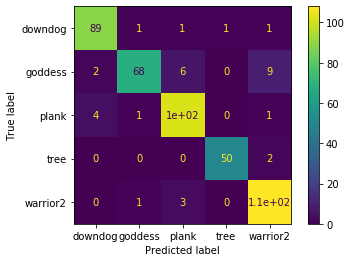

In [72]:
fit_predict(fit_models['gb'], X_test, y_test)

__XGBoost Classifier__

Model name: XGBClassifier
Accuracy score: 0.9333333333333333
classification report

              precision    recall  f1-score   support

     downdog       0.93      0.96      0.94        93
     goddess       0.94      0.85      0.89        85
       plank       0.90      0.94      0.92       108
        tree       0.96      0.96      0.96        52
    warrior2       0.96      0.96      0.96       112

    accuracy                           0.93       450
   macro avg       0.94      0.93      0.93       450
weighted avg       0.93      0.93      0.93       450





C:\Users\Isfan\anaconda3\envs\Capstone-NLP\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


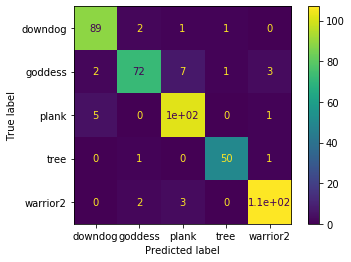

In [71]:
fit_predict(fit_models['xgb'], X_test, y_test)

__Logistic Regression__

Model name: LogisticRegression
Accuracy score: 0.8911111111111111
classification report

              precision    recall  f1-score   support

     downdog       0.91      0.95      0.93        93
     goddess       0.85      0.78      0.81        85
       plank       0.90      0.91      0.90       108
        tree       0.92      0.90      0.91        52
    warrior2       0.89      0.91      0.90       112

    accuracy                           0.89       450
   macro avg       0.89      0.89      0.89       450
weighted avg       0.89      0.89      0.89       450





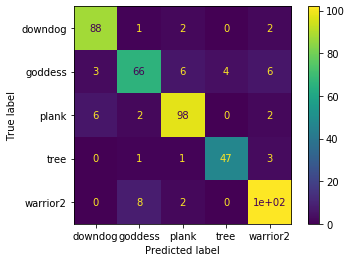

In [73]:
fit_predict(fit_models['lr'], X_test, y_test)

__Ridge Classifier__

Model name: RidgeClassifier
Accuracy score: 0.9155555555555556
classification report

              precision    recall  f1-score   support

     downdog       0.98      0.92      0.95        93
     goddess       0.93      0.84      0.88        85
       plank       0.89      0.92      0.90       108
        tree       0.91      0.92      0.91        52
    warrior2       0.89      0.96      0.92       112

    accuracy                           0.92       450
   macro avg       0.92      0.91      0.91       450
weighted avg       0.92      0.92      0.92       450





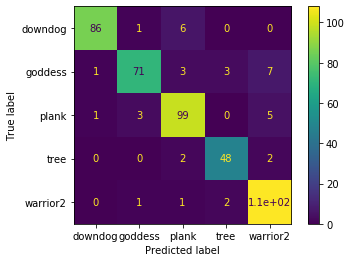

In [74]:
fit_predict(fit_models['rc'], X_test, y_test)

__Random Forest Classifier__

Model name: RandomForestClassifier
Accuracy score: 0.9311111111111111
classification report

              precision    recall  f1-score   support

     downdog       0.96      0.96      0.96        93
     goddess       0.97      0.79      0.87        85
       plank       0.89      0.97      0.93       108
        tree       0.91      0.98      0.94        52
    warrior2       0.94      0.96      0.95       112

    accuracy                           0.93       450
   macro avg       0.93      0.93      0.93       450
weighted avg       0.93      0.93      0.93       450





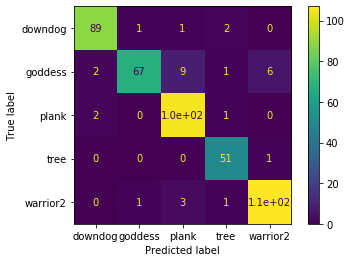

In [75]:
fit_predict(fit_models['rf'], X_test, y_test)

__Support Vector Machines__

Model name: SVC
Accuracy score: 0.6755555555555556
classification report

              precision    recall  f1-score   support

     downdog       0.91      0.85      0.88        93
     goddess       0.00      0.00      0.00        85
       plank       0.72      0.96      0.83       108
        tree       0.92      0.42      0.58        52
    warrior2       0.51      0.88      0.64       112

    accuracy                           0.68       450
   macro avg       0.61      0.62      0.59       450
weighted avg       0.59      0.68      0.61       450





C:\Users\Isfan\anaconda3\envs\Capstone-NLP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


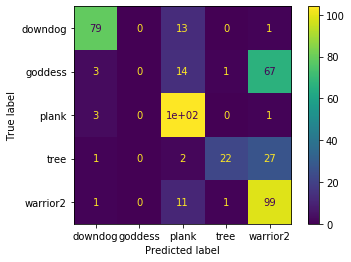

In [76]:
fit_predict(fit_models['svc'], X_test, y_test)

Saving the model in a file

In [92]:
#with open('exercise_fun.pkl', 'wb') as f:
    #pickle.dump(fit_models['gb'], f)

In [49]:
with open('yoga_xgb.pkl', 'wb') as f:
    pickle.dump(fit_models['xgb'], f)

---

## Deep learning

In [158]:
# neural network model
# Create a new sequential model
model = keras.Sequential()
model.add(Dense(132, input_dim=132, activation="relu"))
# Declare the hidden layers
model.add(layers.Dense(66, activation="softmax"))

model.add(Dropout(0.20))

model.add(layers.Dense(132, activation="relu"))

model.add(Dropout(0.20))

model.add(layers.Dense(66, activation="softmax"))

model.add(Dropout(0.20))

model.add(layers.Dense(132, activation="relu"))

model.add(Dropout(0.20))

model.add(layers.Dense(66, activation="softmax"))

model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.5))

# Declare the output layer
model.add(layers.Dense(5,activation="softmax"))

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError(),
    metrics=["accuracy"]
)

#.compile(loss=keras.losses.categorical_crossentropy,optimizer = "adam",metrics=["accuracy"])

# Early Stop
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)

In [159]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 132)               17556     
_________________________________________________________________
dense_156 (Dense)            (None, 66)                8778      
_________________________________________________________________
dropout_75 (Dropout)         (None, 66)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 132)               8844      
_________________________________________________________________
dropout_76 (Dropout)         (None, 132)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 66)                8778      
_________________________________________________________________
dropout_77 (Dropout)         (None, 66)              

In [160]:
epochs = 50
batch_size = 32
num_of_train_samples = X_train.shape[0]
num_of_val_samples = X_test.shape[0]

In [161]:
y_tr = pd.factorize(y_train)

In [162]:
y_tr[0]

array([0, 1, 0, ..., 3, 2, 1], dtype=int64)

In [163]:
history = model.fit(X_train, y_tr[0] , epochs=150, validation_split=0.2, shuffle=True)

Epoch 1/150
27/27 [==============================] - 1s 12ms/step - loss: 1.8986 - accuracy: 0.2172 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 2/150
27/27 [==============================] - 0s 8ms/step - loss: 1.8986 - accuracy: 0.2172 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 3/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.2291 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 4/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.1897 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 5/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.1742 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 6/150
27/27 [==============================] - 0s 8ms/step - loss: 1.8986 - accuracy: 0.2088 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 7/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.1933 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 8/150


Epoch 59/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.2088 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 60/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.2005 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 61/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.1838 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 62/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.2076 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 63/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.1993 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 64/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.2029 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 65/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.2041 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 

27/27 [==============================] - 0s 8ms/step - loss: 1.8986 - accuracy: 0.1933 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 117/150
27/27 [==============================] - 0s 8ms/step - loss: 1.8986 - accuracy: 0.1885 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 118/150
27/27 [==============================] - 0s 8ms/step - loss: 1.8986 - accuracy: 0.2208 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 119/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.1993 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 120/150
27/27 [==============================] - 0s 6ms/step - loss: 1.8986 - accuracy: 0.1981 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 121/150
27/27 [==============================] - 0s 8ms/step - loss: 1.8986 - accuracy: 0.2005 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 122/150
27/27 [==============================] - 0s 7ms/step - loss: 1.8986 - accuracy: 0.2220 - val_loss: 1.8905 - val_accuracy: 0.1286
Epoch 123/150

In [147]:
model.evaluate(X_train, y_train[0])

33/33 [==============================] - 0s 3ms/step - loss: 1.8969 - accuracy: 0.1947


[1.896946668624878, 0.19465649127960205]

We are getting about 20% accuracy, which means the model doesn't work. In the interest of time, we wont be using deep learning and re-visit in future.

---

### Testing webcam by running models

Importing model

In [173]:
with open('yoga.pkl', 'rb') as f:
    model = pickle.load(f)

#### Webcam to do live testing

In [28]:
cap = cv2.VideoCapture(1)

#points counter
points = 0


## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            landmarks_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks]).flatten())
              
                
            # Make Detections
            X = pd.DataFrame([landmarks_row])
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            print(body_language_class, np.round(body_language_prob,2))
            
            if (np.amax(np.round(body_language_prob,2)) > .5):
                
               
                
            # Get status box
                cv2.rectangle(image, (0,0), (590, 60), (100, 100, 10), -1)
            
            # Displaying classification
                cv2.putText(image, 'CLASS', (130,15), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, body_language_class.split(' ')[0], (120,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Displaying probability
                cv2.putText(image, 'PROB', (15,15), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2)), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            
                
            #displaying FEEDBACK
                cv2.putText(image, 'FEEDBACK:', (300,15), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                if (np.amax(np.round(body_language_prob,2)) > .85):
                    points = points + 0.1
                    msg = 'Excellent posture'
                elif  (np.amax(np.round(body_language_prob,2)) > .75):
                    msg = 'Good,can be better'
                else:
                    msg = 'Improve your posture'
                print(points)
                cv2.putText(image, msg, (300,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                
                # Get status box
                cv2.rectangle(image, (0,60), (100, 130), (100, 100, 10), -1)
                cv2.putText(image, 'POINTS:', (15,80), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(points)), (15,120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            
                       
        except:
            pass
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

warrior2 [0.01 0.44 0.03 0.   0.52]
0
goddess [0.01 0.65 0.11 0.   0.22]
0
goddess [0.01 0.64 0.11 0.   0.24]
0
goddess [0.01 0.64 0.11 0.   0.24]
0
goddess [0.01 0.64 0.11 0.   0.24]
0
goddess [0.01 0.61 0.12 0.   0.26]
0
goddess [0.01 0.74 0.19 0.   0.06]
0
goddess [0.01 0.8  0.15 0.   0.05]
0
goddess [0.   0.65 0.13 0.   0.22]
0
goddess [0.01 0.62 0.14 0.   0.24]
0
goddess [0.   0.77 0.17 0.   0.05]
0
goddess [0.01 0.58 0.32 0.   0.08]
0
goddess [0.01 0.61 0.3  0.   0.08]
0
goddess [0.01 0.5  0.21 0.   0.27]
goddess [0.01 0.53 0.17 0.   0.29]
0
goddess [0.01 0.58 0.17 0.   0.23]
0
goddess [0.01 0.47 0.22 0.   0.3 ]
goddess [0.01 0.59 0.17 0.   0.23]
0
goddess [0.01 0.68 0.25 0.   0.06]
0
goddess [0.02 0.61 0.3  0.   0.07]
0
plank [0.03 0.32 0.53 0.   0.12]
0
plank [0.03 0.26 0.58 0.   0.13]
0
plank [0.03 0.3  0.54 0.   0.13]
0
goddess [0.02 0.48 0.4  0.   0.09]
goddess [0.02 0.52 0.37 0.   0.09]
0
plank [0.03 0.33 0.52 0.   0.12]
0
plank [0.04 0.3  0.54 0.   0.13]
0
plank [0.03 0.32

2.600000000000001
goddess [0.01 0.7  0.   0.   0.3 ]
2.600000000000001
goddess [0.   0.72 0.   0.   0.28]
2.600000000000001
goddess [0.   0.75 0.   0.   0.25]
2.600000000000001
goddess [0.01 0.68 0.   0.   0.31]
2.600000000000001
goddess [0.01 0.73 0.   0.   0.26]
2.600000000000001
goddess [0.01 0.66 0.   0.   0.33]
2.600000000000001
goddess [0.01 0.76 0.   0.   0.23]
2.600000000000001
goddess [0.01 0.86 0.   0.01 0.13]
2.700000000000001
goddess [0.01 0.87 0.   0.01 0.12]
2.800000000000001
goddess [0.01 0.96 0.   0.   0.03]
2.9000000000000012
goddess [0.01 0.94 0.   0.   0.05]
3.0000000000000013
goddess [0.01 0.95 0.   0.   0.03]
3.1000000000000014
goddess [0.02 0.8  0.   0.   0.17]
3.1000000000000014
goddess [0.02 0.62 0.   0.   0.35]
3.1000000000000014
goddess [0.02 0.73 0.   0.   0.25]
3.1000000000000014
goddess [0.02 0.71 0.01 0.   0.26]
3.1000000000000014
goddess [0.03 0.69 0.01 0.   0.28]
3.1000000000000014
goddess [0.03 0.65 0.01 0.   0.31]
3.1000000000000014
goddess [0.04 0.52 

goddess [0.01 0.68 0.   0.   0.31]
5.299999999999997
goddess [0.01 0.68 0.   0.   0.31]
5.299999999999997
goddess [0.01 0.87 0.   0.   0.11]
5.399999999999997
goddess [0.03 0.77 0.01 0.   0.19]
5.399999999999997
goddess [0.05 0.57 0.01 0.   0.37]
5.399999999999997
goddess [0.05 0.64 0.01 0.   0.3 ]
5.399999999999997
goddess [0.03 0.55 0.01 0.   0.41]
5.399999999999997
warrior2 [0.02 0.36 0.01 0.   0.61]
5.399999999999997
warrior2 [0.05 0.2  0.01 0.   0.73]
5.399999999999997
warrior2 [0.03 0.44 0.01 0.   0.51]
5.399999999999997
goddess [0.04 0.49 0.02 0.   0.45]
goddess [0.04 0.61 0.01 0.   0.34]
5.399999999999997
goddess [0.03 0.79 0.01 0.   0.17]
5.399999999999997
goddess [0.02 0.78 0.01 0.   0.19]
5.399999999999997
goddess [0.01 0.85 0.   0.   0.13]
5.399999999999997
goddess [0.04 0.61 0.01 0.   0.34]
5.399999999999997
goddess [0.03 0.54 0.01 0.   0.42]
5.399999999999997
warrior2 [0.03 0.27 0.01 0.   0.69]
5.399999999999997
warrior2 [0.03 0.44 0.02 0.   0.52]
5.399999999999997
goddes

6.199999999999994
plank [0.02 0.33 0.54 0.   0.11]
6.199999999999994
goddess [0.01 0.55 0.37 0.   0.08]
6.199999999999994
goddess [0.01 0.55 0.36 0.   0.08]
6.199999999999994
goddess [0.01 0.53 0.38 0.   0.08]
6.199999999999994
goddess [0.01 0.61 0.29 0.   0.09]
6.199999999999994
goddess [0.02 0.47 0.39 0.   0.12]
goddess [0.02 0.42 0.36 0.   0.2 ]
plank [0.02 0.33 0.54 0.   0.11]
6.199999999999994
plank [0.02 0.33 0.54 0.   0.11]
6.199999999999994
plank [0.01 0.38 0.5  0.   0.1 ]
plank [0.02 0.33 0.54 0.   0.11]
6.199999999999994
warrior2 [0.01 0.26 0.27 0.   0.45]
warrior2 [0.01 0.3  0.26 0.   0.43]


## Video files

In [77]:
input_video_path = './videos/pose5.mov'

with open('yoga_xgb.pkl', 'rb') as f:
#with open('exercise_fun.pkl', 'rb') as f:
    model = pickle.load(f)

In [78]:
cap = cv2.VideoCapture(input_video_path)

#points counter
points = 0

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        
       
        # training msg
        #msg="Fix your posture!"
        
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            landmarks_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks]).flatten())
              
                
            # Make Detections
            X = pd.DataFrame([landmarks_row])
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            print(body_language_class, np.round(body_language_prob,2))
            
            if (np.amax(np.round(body_language_prob,2)) > .5):
                
               
                
            # Get status box
                cv2.rectangle(image, (0,0), (590, 60), (100, 100, 10), -1)
            
            # Displaying classification
                cv2.putText(image, 'CLASS', (130,15), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, body_language_class.split(' ')[0], (120,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Displaying probability
                cv2.putText(image, 'PROB', (15,15), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2)), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            
                
            #displaying FEEDBACK
                cv2.putText(image, 'FEEDBACK:', (300,15), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                if (np.amax(np.round(body_language_prob,2)) > .85):
                    points = points + 0.1
                    msg = 'Excellent posture'
                elif  (np.amax(np.round(body_language_prob,2)) > .75):
                    msg = 'Good,can be better'
                else:
                    msg = 'Improve your posture'
                print(points)
                cv2.putText(image, msg, (300,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                
                # Get status box
                cv2.rectangle(image, (0,60), (100, 130), (100, 100, 10), -1)
                cv2.putText(image, 'POINTS:', (15,80), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(points)), (15,120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                
                
        except:
            pass
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

goddess [0.   0.59 0.   0.   0.4 ]
0
warrior2 [0.   0.13 0.   0.   0.87]
0.1
warrior2 [0.   0.06 0.   0.   0.94]
0.2
warrior2 [0.   0.06 0.   0.   0.94]
0.30000000000000004
warrior2 [0.   0.13 0.   0.   0.87]
0.4
warrior2 [0.   0.36 0.   0.   0.63]
0.4
goddess [0.   0.53 0.   0.   0.46]
0.4
warrior2 [0.   0.38 0.   0.   0.61]
0.4
warrior2 [0.01 0.36 0.   0.01 0.63]
0.4
warrior2 [0.   0.12 0.   0.01 0.87]
0.5
warrior2 [0.   0.11 0.   0.   0.88]
0.6
warrior2 [0.   0.12 0.   0.01 0.87]
0.7
warrior2 [0.   0.12 0.   0.01 0.87]
0.7999999999999999
warrior2 [0.01 0.17 0.   0.01 0.81]
0.7999999999999999
warrior2 [0.01 0.16 0.   0.01 0.83]
0.7999999999999999
warrior2 [0.01 0.15 0.   0.01 0.83]
0.7999999999999999
warrior2 [0.01 0.15 0.   0.01 0.84]
0.7999999999999999
warrior2 [0.01 0.15 0.   0.01 0.84]
0.7999999999999999
warrior2 [0.01 0.15 0.   0.01 0.84]
0.7999999999999999
warrior2 [0.01 0.15 0.   0.01 0.84]
0.7999999999999999
warrior2 [0.01 0.15 0.   0.01 0.84]
0.7999999999999999
warrior2 [0.0